In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir('/content/drive/My Drive/Tesi')

In [ ]:
import cv2
import math
import copy
import random
import numpy as np
import pandas as pd
from collections import deque
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from keras.models import load_model
from tensorflow.keras.utils import Sequence

import warnings
warnings.filterwarnings('ignore')

In [ ]:
sequence_length = 4
sequence_stride = 2
batch_size      = 16

# Network model

## Loading the pre-trained model

In [ ]:
ed_path = 'models/urban/ED_urban_pre-trained.h5'
ed = load_model(ed_path)

ed.summary()

## Remove the top layers

In [ ]:
from keras import Model

ed_nofreeze = Model(inputs=ed.input, outputs=ed.layers[-4].output)

for layer in ed_nofreeze.layers:
  layer.trainable = True

# ed_nofreeze.summary()

## CNN + LSTM

In [ ]:
from keras.layers import TimeDistributed, Input, LSTM, Dense, Dropout

input_layer = Input(shape=(sequence_length, 224, 224, 3))
ed_reshaped = TimeDistributed(ed_nofreeze)(input_layer)
CNNandLSTM = LSTM(100, activation='relu')(ed_reshaped)
dropout = Dropout(0.5)(CNNandLSTM)
output = Dense(1, activation='sigmoid')(dropout)

model = Model(inputs=input_layer, outputs=output)
model.summary()

In [ ]:
model.save('models/urban/ED_LSTM_urban_trainable_True.h5')

# Inference with pre-trained CNN on single test frames

In [ ]:
path = 'csv/Test/urban/KFold_long-range/fold2'
csvs = os.listdir(path)
test_data = {'filename':[], 'Flames':[]}

for csv in csvs:
    temp = pd.read_csv(path + '/' + csv)
    for index, row in temp.iterrows():
      test_data['filename'].append(row['filename'])
      test_data['Flames'].append(row['Flames'])

test_data = pd.DataFrame(test_data)
print("Test data samples: " + str(len(test_data)) + ".\nPositive test frames: " +
      str(test_data[test_data['Flames'] == 1].count()[0]) + ".\nNegative test frames: " +
      str(test_data[test_data['Flames'] == 0].count()[0]) + ".")

In [ ]:
# putting our test data labels in the proper format and shape desired
col = test_data['Flames']
col = list(col)

t = []
for i in col:
  t.append(str(i))

td = {'filename':[], 'Flames':[]}

for index, row in test_data.iterrows():
  td['filename'].append(row['filename'])
  td['Flames'].append(t[index])

test_data = pd.DataFrame(td)

In [ ]:
new_test_data = {'filename':[], 'Flames':[]}

for index, row in test_data.iterrows():
  new_test_data['filename'].append('/content/drive/My Drive' + row['filename'][30:])
  new_test_data['Flames'].append(str(row['Flames']))

n_t_d = pd.DataFrame(new_test_data)

In [ ]:
import tensorflow
from tensorflow import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard, CSVLogger, EarlyStopping

test_datagen = ImageDataGenerator(preprocessing_function = tensorflow.keras.applications.efficientnet.preprocess_input)

test_generator = test_datagen.flow_from_dataframe(dataframe = n_t_d, 
                                                    x_col='filename', 
                                                    y_col='Flames', 
                                                    class_mode='binary',
                                                    target_size=(224,224),
                                                    batch_size=32,
                                                    shuffle=False)

In [ ]:
from keras.models import load_model

mnv2_path = 'models/urban/ED_urban_pre-trained.h5'
mnv2 = load_model(mnv2_path)

pred = mnv2.predict(test_generator)

67/67 [==============================] - 196s 3s/step


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_cm(y, pred):
  p = pred.argmax(-1)
  cm = confusion_matrix(y, p)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()
  plt.title('Accuracy: %.3f' % (y==p).mean())
  plt.show()

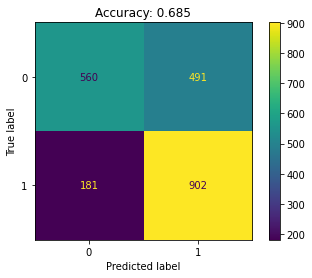

In [ ]:
test_lab = []
for i in list(n_t_d['Flames']):
  test_lab.append(int(i))
plot_cm(y=test_lab, pred=pred)

# Evaluate

In [ ]:
# tensorflow version must be the 2.6.2 and keras version must be 2.6.0.
!pip install tensorflow==2.6.2
%tensorflow_version 2.6.2

# !!!!!!!!!!!!!! AFTER EXECUTING THIS CELL, RESTART THE RUNTIME !!!!!!!!!!!!!!!!

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 458.4/458.4 MB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 80.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.0/132.0 KB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 KB 6.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.9/462.9 KB 51.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 109.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.9/14.9 MB 82.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 152.9/152.9 KB 25.2 MB/s eta 0:00:00
  Created wheel for clang: filename=clang-5.0-py3-none-any.whl size=30694 sha256=1f439ccd95f4c8a383d477076659010700cb66bb5753625562382

In [ ]:
import tensorflow
print(tensorflow.__version__)

2.6.2


In [ ]:
from tensorflow import keras
print(keras.__version__)

2.6.0


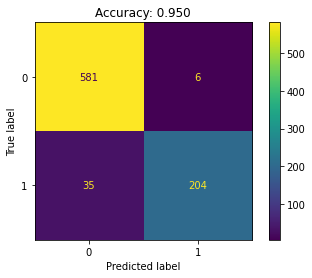

In [ ]:
import os
import cv2
import math
import copy
from collections import deque
import matplotlib.pyplot as plt
from sklearn.utils import shuffle
from sklearn.utils.class_weight import compute_class_weight

def file_generator(data_path, data_files, temporal_stride, temporal_length):
  '''
  data_files - list of csv files to be read
  '''
  for f in data_files:
    tmp_df = pd.read_csv(os.path.join(data_path, f))
    total_images = len(tmp_df)
    if total_images >= temporal_length:
      num_samples = int((total_images - temporal_length)/temporal_stride) + 1
      # print('num of samples from vid seq-{}: {}'.format(f, num_samples))
    else:
      # print('num of frames is less than temporal length; hence discarding this \
      #       file-{}'.format(f))
      continue

    samples = deque()
    labels = deque()

    for index, row in tmp_df.iterrows():
      samples.append('/content/drive/My Drive' + row['filename'][30:])
      labels.append(int(row['Flames']))
      if len(samples) == temporal_length:
        to_delete = False
        if labels.count(labels[0]) != len(labels):
          to_delete = True
        samples_c = copy.deepcopy(samples)
        for t in range(temporal_stride):
          samples.popleft()
          labels.popleft()
        if to_delete: continue
        yield samples_c, labels[0]

def load_samples(CSV_folder, temporal_stride, temporal_length):
  data_path = os.path.join('csv', CSV_folder)
  data_files = os.listdir(data_path)
  file_gen = file_generator(data_path, data_files, temporal_stride, temporal_length)
  iterator = True
  data_list = []

  while iterator:
    try:
      x, y = next(file_gen)
      x = list(x)
      data_list.append([x, y])
    except Exception as e:
      # print('Exception: ', e)
      iterator = False
      # print('end of data generator ')
  return data_list

class DataGenerator(Sequence):

    def __init__(self, data, batch_size, shuffle_data, aug):
        self.num_samples = len(data)
        self.data = shuffle(data) if shuffle_data else data
        self.batch_size = batch_size
        self.aug = aug        
        self.additional_targets = {[f'image{i}' for i in range(sequence_length-1)][j]:'image' for j in range(sequence_length-1)}

    def __len__(self):
        return math.ceil(len(self.data) / self.batch_size)

    def __getitem__(self, idx):
        #print('starting index: ', idx * self.batch_size)
        batch_samples = self.data[idx * self.batch_size:(idx + 1) * self.batch_size]
        X_train = []
        y_train = []
        for batch_sample in batch_samples:
            x = batch_sample[0]   # Load image (X)
            y = batch_sample[1]   # Read label (y)
            temp_data_list = []
            for img_name in x:
                try:
                    img = cv2.imread(img_name)
                    img = cv2.resize(img, (224,224))
                    temp_data_list.append(img[:,:, ::-1])
                except Exception as e:
                    print(e)
                    print('error reading file: ', img_name)
            if self.aug:
                temp_data_list = self.__totransform__(temp_data_list)
            # Add example to arrays
            X_train.append(temp_data_list)
            y_train.append(y)
        # Make sure they're numpy arrays (as opposed to lists)
        X_train = np.array(X_train)
        y_train = np.array(y_train)
        return X_train, y_train
    
    def __totransform__(self, list_of_frames):

        transform = A.Compose([   
            A.HorizontalFlip(p=0.5),
            A.OneOf(
              [
                # A.Blur(p=0.01, blur_limit=(3, 7)),
                # A.MedianBlur(p=0.01, blur_limit=(3, 7)),
                # A.MotionBlur(p=0.01, blur_limit=(3, 7)),
                # A.GaussianBlur(p=0.01, blur_limit=(3, 7), sigma_limit=(0.0, 0)),
                # A.ZoomBlur(p=0.01, max_factor=(1.0, 1.12), step_factor=(0.01, 0.03)),
                # A.Defocus(p=0.01, radius=(1, 4), alias_blur=(0.1, 0.5)),
                # A.RingingOvershoot(p=0.01, blur_limit=(7, 15), cutoff=(0.7, 1.57)),
                # A.Downscale(p=0.01, scale_min=0.8, scale_max=0.99),
                # A.ImageCompression(p=0.01, quality_lower=80, quality_upper=100,
                #                     compression_type=0),
                # A.JpegCompression(p=0.01, quality_lower=80, quality_upper=100),
                # A.GaussNoise(p=0.01, var_limit=(10, 50), per_channel=True, mean=0.0),
                # A.MultiplicativeNoise(p=0.01, multiplier=(0.9, 1.1), 
                #                         per_channel=True, elementwise=True),
                # A.CLAHE(p=0.01, clip_limit=(1,4), tile_grid_size=(8, 8)),
                # A.Sharpen(p=0.01, alpha=(0.2, 0.5), lightness=(0.5, 1.0)),
                # A.UnsharpMask(p=0.01, blur_limit=(3, 7), sigma_limit=(0.0, 0.0),
                #                 alpha=(0.2, 0.5), threshold=10),
                # A.Emboss(p=0.01, alpha=(0.2, 0.5), strength=(0.2, 0.7)),
                # A.RandomBrightness(p=0.01, limit=(-0.2, 0.2)),
                # A.RandomContrast(p=0.01, limit=(-0.2, 0.2)),
                # A.RandomBrightnessContrast(p=0.01, brightness_limit=(-0.2, 0.2),
                #                             contrast_limit=(-0.2, 0.2), 
                #                             brightness_by_max=True),
                # A.ISONoise(p=0.01, intensity=(0.1, 0.5), color_shift=(0.01, 0.05)),
                # A.Equalize(p=0.01, mode='cv', by_channels=False),             
                # A.FancyPCA(p=0.01, alpha=0.1),
                # A.RGBShift(p=0.01, r_shift_limit=(-20, 20), 
                #             g_shift_limit=(-20, 20), b_shift_limit=(-20, 20)),
                # A.RandomGamma(p=0.01, gamma_limit=(80, 120), eps=None),
                # A.RandomToneCurve(p=0.01, scale=0.1),
                A.SafeRotate(p=0.01, limit=(-90, 90), interpolation=0, 
                              border_mode=0, value=(0, 0, 0), mask_value=None),
                A.OpticalDistortion(p=0.01, distort_limit=(-0.3, 0.3),
                                      shift_limit=(-0.05, 0.05), interpolation=0,
                                      border_mode=0, value=(0, 0, 0), mask_value=None),
                A.GridDistortion(p=0.01, num_steps=5, distort_limit=(-0.3, 0.3),
                                  interpolation=0, border_mode=0, value=(0, 0, 0),
                                  mask_value=None, normalized=False),
                A.Perspective(p=0.01, scale=(0.05, 0.1), keep_size=0, pad_mode=0,
                                pad_val=(0, 0, 0), mask_pad_val=0, fit_output=0, 
                                interpolation=0),
                A.PiecewiseAffine(p=0.01, scale=(0.03, 0.05), nb_rows=(4, 4), 
                                    nb_cols=(4, 4), interpolation=0,
                                    mask_interpolation=0, cval=0, cval_mask=0,
                                    mode='constant', absolute_scale=0, 
                                    keypoints_threshold=0.01),
                A.RandomCropFromBorders(p=0.01, crop_left=0.1, crop_right=0.1, 
                                          crop_top=0.1, crop_bottom=0.1),
                # A.CoarseDropout(p=0.01, max_holes=8, max_height=8, max_width=8, 
                #                   min_holes=8, min_height=8, min_width=8, 
                #                   fill_value=(0, 0, 0), mask_fill_value=None),
                # A.PixelDropout(p=0.01, dropout_prob=0.01, per_channel=0, 
                #                 drop_value=(0, 0, 0), mask_drop_value=None),
                # A.RandomFog(p=0.01, fog_coef_lower=0.2, fog_coef_upper=0.2, 
                #               alpha_coef=0.08),
                # A.RandomSnow(p=0.01, snow_point_lower=0.1, snow_point_upper=0.1, 
                #               brightness_coeff=2),
                # A.RandomRain(p=0.01, slant_lower=-10, slant_upper=10, 
                #               drop_length=20, drop_width=1, drop_color=(0, 0, 0),
                #               blur_value=3, brightness_coefficient=0.7, rain_type=None),
                # A.Spatter(p=0.01, mean=(0.65, 0.65), std=(0.3, 0.3), 
                #             gauss_sigma=(2.0, 2.0), intensity=(0.6, 0.6), 
                #             cutout_threshold=(0.68, 0.68), mode=['rain']),
                # A.Spatter(p=0.01, mean=(0.65, 0.65), std=(0.3, 0.3), 
                #             gauss_sigma=(2.0, 2.0), intensity=(0.6, 0.6), 
                #             cutout_threshold=(0.68, 0.68), mode=['mud']),
              ], p=0.8),
        ], additional_targets=self.additional_targets)

        transformed = transform(image=list_of_frames[0], 
                                image0=list_of_frames[1], 
                                image1=list_of_frames[2],
                                image2=list_of_frames[3])
        
        return  [   cv2.resize(transformed['image'], (224,224)),
                    cv2.resize(transformed['image0'], (224,224)),
                    cv2.resize(transformed['image1'], (224,224)),
                    cv2.resize(transformed['image2'], (224,224))    ]

test_data = load_samples(CSV_folder='Test/urban/KFold_long-range/fold2', temporal_stride=sequence_stride,
                            temporal_length=sequence_length)

test_gen = DataGenerator(data=test_data, batch_size=batch_size, 
                         shuffle_data=False, aug=False)

model = load_model('models/urban/long-range/EfficientDet/case8/case8_best_model2.h5')

# def plot_cm(data, pred):
#   y = data["Labels"].values.astype(np.uint8)
#   p = pred.argmax(-1)
#   print('Accuracy: %.3f' % (y==p).mean())

groundtruth = []
for sample in test_data:
  groundtruth.append(sample[1])

pred = model.predict(test_gen)
predictions = []
for i in range(len(pred)):
  if pred[i][0] > 0.5:
    predictions.append(1)
  else:
    predictions.append(0)

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

def plot_cm(data, pred):
  y = np.array(data)
  p = np.array(pred)
  cm = confusion_matrix(y, p)
  disp = ConfusionMatrixDisplay(confusion_matrix=cm)
  disp.plot()
  plt.title('Accuracy: %.3f' % (y==p).mean())
  plt.show()
plot_cm(data=groundtruth, pred=predictions)

In [ ]:
model.evaluate(test_gen)

52/52 [==============================] - 190s 4s/step - loss: 0.1649 - accuracy: 0.9504


[0.16486124694347382, 0.9503632187843323]

In [ ]:
p = []
for i in pred:
  p.append(round(list(i)[0]))
p = np.array(p)
y = np.array(groundtruth)

groundtruth = list(y)
scores = list(p)

In [ ]:
from keras.metrics import AUC # Approximates the Area Under the Curve of the ROC curve
from sklearn.metrics import balanced_accuracy_score

b_acc = balanced_accuracy_score(y_true=y, y_pred=p)

TP=TN=FP=FN = 0

for i in range(len(groundtruth)):
    if groundtruth[i] == 1 and scores[i] == 1:
        TP = TP + 1
    elif groundtruth[i] == 0 and scores[i] == 0:
        TN = TN + 1
    elif groundtruth[i] == 0 and scores[i] == 1:
        FP = FP + 1
    elif groundtruth[i] == 1 and scores[i] == 0:
        FN = FN + 1

AR = (TP + TN)/(TP + TN + FP + FN)
Precision = TP/(TP + FP)
Recall = TP/(TP + FN)
TPR = TP/(TP + FN)
TNR = TN/(TN + FP)
FPR = FP/(FP + TN)
FNR = FN/(FN + TP)
F1score = (2 * Precision * Recall)/(Precision + Recall)
Auc = AUC()
Auc.update_state(groundtruth, scores)

print("True Positives: " + str(TP) + "\nTrue Negatives: " + str(TN) + 
      "\nFalse Positives: " + str(FP) + "\nFalse Negatives: " + str(FN) +
      "\nTrue Positive rate: " + str(round(TPR, 3)) + "\nTrue negative rate: " +
      str(round(TNR, 3)) + "\nFalse Positive rate: " + str(round(FPR, 3)) +
      "\nFalse Negative rate: " + str(round(FNR, 3)) + "\nAccuracy Rate: " + 
      str(round(AR, 3)) + "\nPrecision: " + str(round(Precision, 3)) + 
      "\nRecall: " + str(round(Recall, 3)) + "\nBalanced accuracy: " + 
      str(round(b_acc, 3)) + "\nF1-Score: " + str(round(F1score, 3)) + 
      "\nArea under ROC curve: " + str(round(float(Auc.result()), 3)))

True Positives: 204
True Negatives: 581
False Positives: 6
False Negatives: 35
True Positive rate: 0.854
True negative rate: 0.99
False Positive rate: 0.01
False Negative rate: 0.146
Accuracy Rate: 0.95
Precision: 0.971
Recall: 0.854
Balanced accuracy: 0.922
F1-Score: 0.909
Area under ROC curve: 0.922


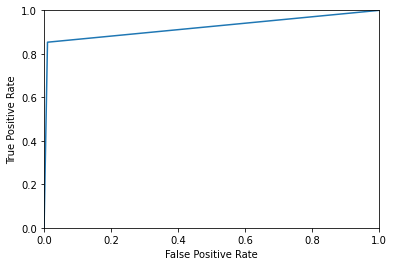

In [ ]:
from sklearn.metrics import roc_curve

def plot_roc_curve(fpr,tpr): 
  plt.plot(fpr,tpr) 
  plt.axis([0,1,0,1]) 
  plt.xlabel('False Positive Rate') 
  plt.ylabel('True Positive Rate') 
  plt.show()

p = []
for i in pred:
  p.append(round(list(i)[0]))
p = np.array(p)

fpr_keras, tpr_keras, thresholds_keras = roc_curve(y_true=np.array(groundtruth), y_score=p)
plot_roc_curve(fpr_keras,tpr_keras)

## Which samples are wrongly predicted?

In [ ]:
wrong_predictions01 = []

for i in range(len(groundtruth)):
    if test_data[i][1] == 0 and scores[i] == 1:
      wrong_predictions01.append(test_data[i][0])
for i in range(len(wrong_predictions01)):
  print(wrong_predictions01[i])

['/content/drive/My Drive/Tesi/datasets/urban/long-range/iStock/frames/negative/istockphoto-1328393940-640_adpp_is.mp4/29.jpg', '/content/drive/My Drive/Tesi/datasets/urban/long-range/iStock/frames/negative/istockphoto-1328393940-640_adpp_is.mp4/30.jpg', '/content/drive/My Drive/Tesi/datasets/urban/long-range/iStock/frames/negative/istockphoto-1328393940-640_adpp_is.mp4/31.jpg', '/content/drive/My Drive/Tesi/datasets/urban/long-range/iStock/frames/negative/istockphoto-1328393940-640_adpp_is.mp4/32.jpg']
['/content/drive/My Drive/Tesi/datasets/urban/long-range/iStock/frames/negative/istockphoto-1328393940-640_adpp_is.mp4/31.jpg', '/content/drive/My Drive/Tesi/datasets/urban/long-range/iStock/frames/negative/istockphoto-1328393940-640_adpp_is.mp4/32.jpg', '/content/drive/My Drive/Tesi/datasets/urban/long-range/iStock/frames/negative/istockphoto-1328393940-640_adpp_is.mp4/33.jpg', '/content/drive/My Drive/Tesi/datasets/urban/long-range/iStock/frames/negative/istockphoto-1328393940-640_adp

In [ ]:
wrong_predictions10 = []

for i in range(len(groundtruth)):
    if test_data[i][1] == 1 and scores[i] == 0:
      
      wrong_predictions10.append(test_data[i][0])
for i in range(len(wrong_predictions10)):
  print(wrong_predictions10[i])

['/content/drive/My Drive/Tesi/datasets/urban/long-range/Bilkent dataset/frames/positive/sBehindtheFence.avi/85.jpg', '/content/drive/My Drive/Tesi/datasets/urban/long-range/Bilkent dataset/frames/positive/sBehindtheFence.avi/86.jpg', '/content/drive/My Drive/Tesi/datasets/urban/long-range/Bilkent dataset/frames/positive/sBehindtheFence.avi/87.jpg', '/content/drive/My Drive/Tesi/datasets/urban/long-range/Bilkent dataset/frames/positive/sBehindtheFence.avi/88.jpg']
['/content/drive/My Drive/Tesi/datasets/urban/long-range/Bilkent dataset/frames/positive/sBehindtheFence.avi/87.jpg', '/content/drive/My Drive/Tesi/datasets/urban/long-range/Bilkent dataset/frames/positive/sBehindtheFence.avi/88.jpg', '/content/drive/My Drive/Tesi/datasets/urban/long-range/Bilkent dataset/frames/positive/sBehindtheFence.avi/89.jpg', '/content/drive/My Drive/Tesi/datasets/urban/long-range/Bilkent dataset/frames/positive/sBehindtheFence.avi/90.jpg']
['/content/drive/My Drive/Tesi/datasets/urban/long-range/Bilke

In [ ]:
all_videos = {'name':[], 'num':[]}

video_name = test_data[0][0][0]
uno = video_name[55:]
revers_uno = uno[::-1]
last_slash = revers_uno.index('/') + 1
semifinal = video_name[55:-last_slash]
rev = semifinal[::-1]
penultimo = rev.index('/')
final = semifinal[-penultimo:]
temp = final
count = 0

for list_of_lists in test_data:
  video_name = list_of_lists[0][0]
  uno = video_name[55:]
  revers_uno = uno[::-1]
  last_slash = revers_uno.index('/') + 1
  semifinal = video_name[55:-last_slash]
  rev = semifinal[::-1]
  penultimo = rev.index('/')
  final = semifinal[-penultimo:]
  
  if final != temp:
    all_videos['name'].append(temp)
    all_videos['num'].append(count)
    count = 0
    temp = final
  count += 1
all_videos['name'].append(temp)
all_videos['num'].append(count)

df = pd.DataFrame(all_videos)
df

,name,num
0,Car_Counting.mp4,28
1,sBehindtheFence.avi,49
2,depositphotos_238566672-stock-video-fireworks-...,15
3,depositphotos_346804950-stock-video-fire-car-c...,6
4,depositphotos_357946754-stock-video-powerful-w...,28
5,depositphotos_390165084-stock-video-police-lig...,13
6,negsVideo12.1074.avi,24
7,negsVideo16.1077.avi,9
8,testneg06.812.avi,9
9,testneg09.815.avi,27


In [ ]:
for index,row in df.iterrows():
  print(row['name'])

Car_Counting.mp4
sBehindtheFence.avi
depositphotos_238566672-stock-video-fireworks-salute-the-night-drone.mp4
depositphotos_346804950-stock-video-fire-car-city-street-man.mp4
depositphotos_357946754-stock-video-powerful-water-jet-shoots-flame.mp4
depositphotos_390165084-stock-video-police-lights-smoke-fire-city.mp4
negsVideo12.1074.avi
negsVideo16.1077.avi
testneg06.812.avi
testneg09.815.avi
testpos05.821.avi
istockphoto-1150482962-640_adpp_is.mp4
istockphoto-1172002357-640_adpp_is.mp4
istockphoto-1209631057-640_adpp_is.mp4
istockphoto-1227253428-640_adpp_is.mp4
istockphoto-1254166542-640_adpp_is.mp4
istockphoto-1271222709-640_adpp_is.mp4
istockphoto-1279238081-640_adpp_is.mp4
istockphoto-1292738876-640_adpp_is.mp4
istockphoto-1303766696-640_adpp_is.mp4
istockphoto-1304967660-640_adpp_is.mp4
istockphoto-1307802889-640_adpp_is.mp4
istockphoto-1328393940-640_adpp_is.mp4
istockphoto-1347566222-640_adpp_is.mp4
istockphoto-1357027590-640_adpp_is.mp4
istockphoto-1371845881-640_adpp_is.mp4
is

In [ ]:
all_videos = {'name':[], 'num':[]}

video_name = wrong_predictions10[0][0]
uno = video_name[55:]
revers_uno = uno[::-1]
last_slash = revers_uno.index('/') + 1
semifinal = video_name[55:-last_slash]
rev = semifinal[::-1]
penultimo = rev.index('/')
final = semifinal[-penultimo:]
temp = final
count = 0

for list_of_lists in wrong_predictions10:
  video_name = list_of_lists[0]
  uno = video_name[55:]
  revers_uno = uno[::-1]
  last_slash = revers_uno.index('/') + 1
  semifinal = video_name[55:-last_slash]
  rev = semifinal[::-1]
  penultimo = rev.index('/')
  final = semifinal[-penultimo:]
  
  if final != temp:
    all_videos['name'].append(temp)
    all_videos['num'].append(count)
    count = 0
    temp = final
  count += 1
all_videos['name'].append(temp)
all_videos['num'].append(count)

df_wrong10 = pd.DataFrame(all_videos)
df_wrong10

,name,num
0,sBehindtheFence.avi,14
1,istockphoto-1434212346-640_adpp_is.mp4,3
2,petrochemical-plant-torch-1163768-PREVIEW.mp4,3
3,Pexels Videos 2080320.mp4,5
4,pexels-alan-w-8365990.mp4,10


In [ ]:
for index,row in df_wrong10.iterrows():
  print(row['name'])

sBehindtheFence.avi
istockphoto-1434212346-640_adpp_is.mp4
petrochemical-plant-torch-1163768-PREVIEW.mp4
Pexels Videos 2080320.mp4
pexels-alan-w-8365990.mp4


In [ ]:
all_videos = {'name':[], 'num':[]}

video_name = wrong_predictions01[0][0]
uno = video_name[55:]
revers_uno = uno[::-1]
last_slash = revers_uno.index('/') + 1
semifinal = video_name[55:-last_slash]
rev = semifinal[::-1]
penultimo = rev.index('/')
final = semifinal[-penultimo:]
temp = final
count = 0

for list_of_lists in wrong_predictions01:
  video_name = list_of_lists[0]
  uno = video_name[55:]
  revers_uno = uno[::-1]
  last_slash = revers_uno.index('/') + 1
  semifinal = video_name[55:-last_slash]
  rev = semifinal[::-1]
  penultimo = rev.index('/')
  final = semifinal[-penultimo:]
  
  if final != temp:
    all_videos['name'].append(temp)
    all_videos['num'].append(count)
    count = 0
    temp = final
  count += 1
all_videos['name'].append(temp)
all_videos['num'].append(count)

df_wrong01 = pd.DataFrame(all_videos)
df_wrong01

,name,num
0,istockphoto-1328393940-640_adpp_is.mp4,6


In [ ]:
for index,row in df_wrong01.iterrows():
  print(row['name'])

istockphoto-1328393940-640_adpp_is.mp4
